In [46]:
import pandas as pd
import numpy as numpy
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_profiling as pdp
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy.random as random
import scipy as sp
from sklearn.metrics import precision_score, recall_score, f1_score
df = pd.read_csv('./data/ks-projects-201801.csv')

## データ前処理

In [47]:
df.drop(['usd pledged'], axis=1, inplace=True)

re_df = df[(df['state'] == 'successful') | (df['state'] == 'canceled')]
re_df = re_df[re_df['goal'] <= 27750]

re_df['deadline'] = pd.to_datetime(df['deadline'])
re_df['launched'] = pd.to_datetime(df['launched'])
re_df['period'] = re_df['deadline'] - re_df['launched']
re_df['period'] = re_df['period'].map(lambda x: x.total_seconds()/(60*60*24))
re_df = re_df[re_df['period'] <= 60]

In [48]:
re_df.drop(['ID', 'name', 'deadline', 'launched'], axis=1, inplace=True)

oe = OrdinalEncoder()
cat_list = ['category','main_category','currency','state', 'country']
re_df[cat_list] = oe.fit_transform(re_df[cat_list].values)

<AxesSubplot: >

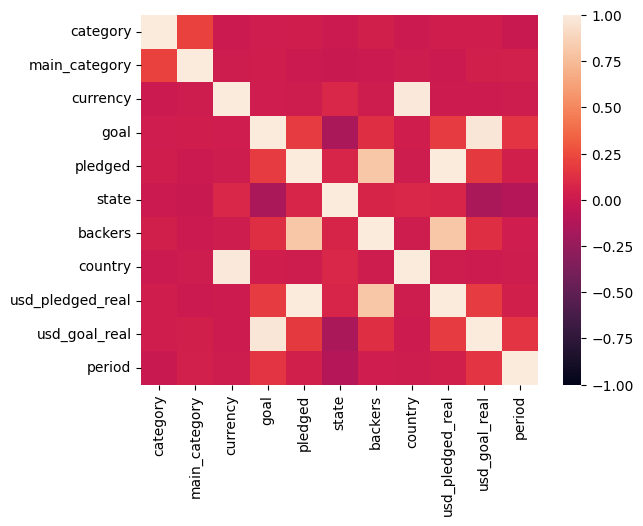

In [49]:
corr = re_df.corr()
sns.heatmap(corr,  vmin = -1, vmax = 1)

In [50]:
#　相関分析の結果から特徴量選定
re_df.drop(['currency', 'goal', 'pledged', 'backers'], axis=1, inplace=True)

In [51]:
# データの準備
col = 'state'
X = re_df.drop(col, axis=1)
Y = re_df[col]

# 説明変数の標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# データ分割
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## 決定木モデル(ハイパラチューニングなし)

In [52]:
from sklearn.tree import plot_tree
from IPython.display import Image
import pydotplus
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [54]:
# 交差検証なし
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
tree_model.fit(X_train, Y_train)


# 訓練データの識別率
result = tree_model.score(X_train, Y_train)
# print(result)

# テストデータの識別率
result = tree_model.score(X_val, Y_val)
# print(result)

pred = tree_model.predict(X_val)
score_tree = metrics.accuracy_score(Y_val, pred)
# plt.figure(figsize=(15, 10))
# plot_tree(tree_model, feature_names=re_df.drop(col, axis=1).columns, class_names=True, filled=True)
# plt.show()

0.989865625703776
0.9899242651719882


## 決定木モデル（グリッドサーチによるハイパラチューニング）

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from IPython.display import Image
import pydotplus
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

In [64]:
# 学習に使用するアルゴリズムの定義
tree_params = {DecisionTreeClassifier(): {"criterion": ["gini", "entropy"],
                                          "splitter": ["best", "random"],
                                          "max_depth": [i for i in range(1, 11)],
                                          "min_samples_split": [i for i in range(2, 11)],
                                          "min_samples_leaf": [i for i in range(1, 11)],
                                          "random_state": [0]}}

max_score = 0
#決定木の実行
for model, param in tqdm(tree_params.items()):
    clf = GridSearchCV(model, param, scoring='roc_auc')
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_val)
    # score = f1_score(Y_val, pred, average="micro")
    score = metrics.accuracy_score(Y_val, pred)

    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

# print("ベストスコア:{}".format(max_score))
# print("モデル:{}".format(best_model))
# print("パラメーター:{}".format(best_param))
score_tree_grid = max_score

100%|██████████| 1/1 [2:31:45<00:00, 9105.22s/it]


In [65]:
score_tree_grid 

0.9943282287391986

## K-NN（ランダムサーチによるハイパラチューニング）

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

In [67]:
knn_params = {KNeighborsClassifier():{'n_neighbors':[i for i in range(1, 30)],
                                     'weights':['uniform','distance'], 'p':[1,2]}}

max_score = 0
best_param = None
for model, param in tqdm(knn_params.items()):
    # ランダムサーチを生成
    clf = RandomizedSearchCV(model, param)
    # 訓練の実行
    clf.fit(X_train, Y_train)
    # データの予測と正解率の計算
    pred = clf.predict(X_val)
    score = metrics.accuracy_score(Y_val, pred)
    # 最高スコアの更新
    if max_score < score:
        max_score = score
        best_param = clf.best_params_
    # # パラメータの組み合わせを確認
    # print(clf.cv_results_["params"])
# print(f"ハイパーパラメータ: {best_param}")
# print(f"最高スコア: {max_score}")
score_knn_randomsearch = max_score

100%|██████████| 1/1 [11:15<00:00, 675.73s/it]


## K-NN（ベイズ最適化によるハイパラチューニング)

In [68]:
from skopt import BayesSearchCV

# データ分割
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(weights='distance', p=1)
bayes_params = {'n_neighbors':(1, 100)}

clf = BayesSearchCV(
    estimator=knn_model,
    search_spaces=bayes_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    n_iter=30,
    verbose=1,
    refit=True
)

clf.fit(X_trainval, Y_trainval)
pred = clf.predict(X_test)
score_knn_bayes = metrics.accuracy_score(Y_test, pred)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

## 精度比較

In [74]:
print('決定木（ハイパラチューニングなし）:', score_tree)
print('決定木（グリッドサーチによるハイパラチューニング）:', score_tree_grid)
print('K-NN（ランダムサーチによるハイパラチューニング）:', score_knn_randomsearch)
print('K-NN（ベイズ最適化によるハイパラチューニング）:', score_knn_bayes)

決定木（ハイパラチューニングなし）: 0.9899242651719882
決定木（グリッドサーチによるハイパラチューニング）: 0.9943282287391986
K-NN（ランダムサーチによるハイパラチューニング）: 0.9253661628799252
K-NN（ベイズ最適化によるハイパラチューニング）: 0.9180595869615987
